In [16]:
import pandas as pd
import numpy as np
from statsmodels.miscmodels.ordinal_model import OrderedModel
import seaborn as sns

import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from scipy.stats import gaussian_kde
from sklearn.metrics.pairwise import haversine_distances
import math
from math import radians
import geopandas as gpd

from shapely.geometry import Point
from shapely import wkt
import contextily as ctx
from sklearn.neighbors import KernelDensity
import textwrap

In [17]:
import os

# Change to your new working directory
os.chdir(r'C:\Users\jcoll\Desktop\Everything\Berkeley Spring 2025\Thesis\Data\Python_Survey')

# Verify the working directory
print(os.getcwd())

#######

survey = pd.read_csv('Students_OD_FromGIS - Anonym.csv',  encoding='windows-1252')

survey = survey.iloc[1:].reset_index(drop=True)
survey.columns

def choose_tt(row):
    if row['Question_12'] in ['Public transit (bus/BART)', 'Walk/bike/scooter']:
        if pd.notna(row['Bus/Bike/Walk Time']):
            return row['Bus/Bike/Walk Time']
        else:
            return row['Total_TravelTime']
    else:
        return row['Total_TravelTime']

survey['tt'] = survey.apply(choose_tt, axis=1)



C:\Users\jcoll\Desktop\Everything\Berkeley Spring 2025\Thesis\Data\Python_Survey


In [18]:
summary = survey.groupby('Question_9')['tt'].describe()


In [19]:
survey.columns
clean2 = survey[['tt', 'Question_9', 'Question_6', 'Unique to School', 'Question_10', 'Question_11']]

166
152


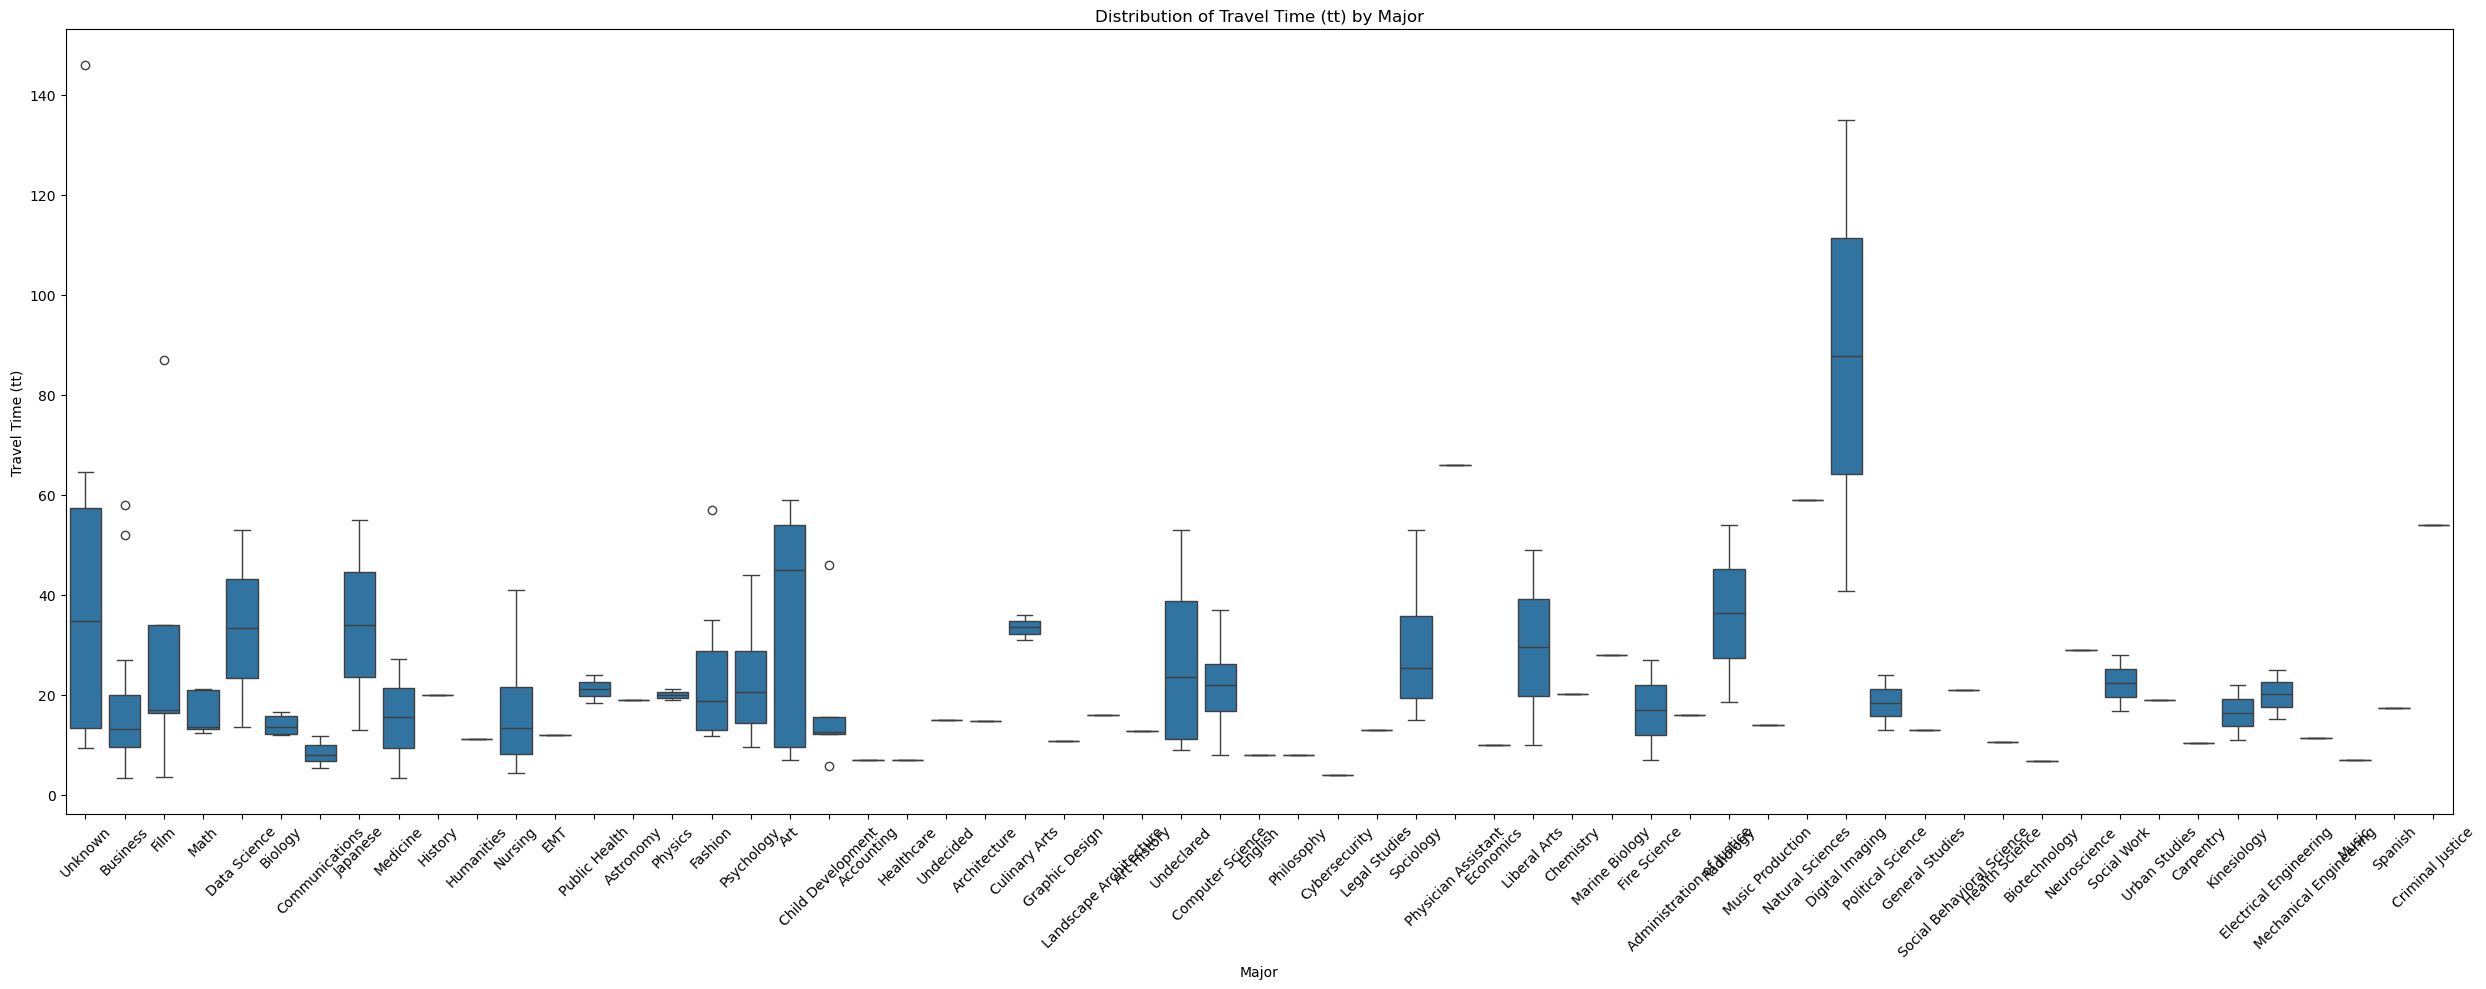

In [ ]:
clean = survey[['tt', 'Question_9', 'Question_6', 'Unique to School']].copy()


print(len(clean))
# # Replace strings that represent missing values with actual np.nan
# clean['tt'] = clean['tt'].replace(['NaN', 'nan', 'NA', ''], np.nan)

# Now drop rows with NaN in 'tt'
clean = clean.dropna(subset=['tt'])
print(len(clean))


# Assuming your DataFrame is named 'clean'
# Step 1: Explode majors
clean['Question_9'] = clean['Question_9'].str.split(', ')
exploded = clean.explode('Question_9')

# Step 2: Plot boxplot2
plt.figure(figsize=(25, 10))
sns.boxplot(x='Question_9', y='tt', data=exploded)
plt.title('Distribution of Travel Time (tt) by Major')
plt.xlabel('Major')
plt.ylabel('Travel Time (tt)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


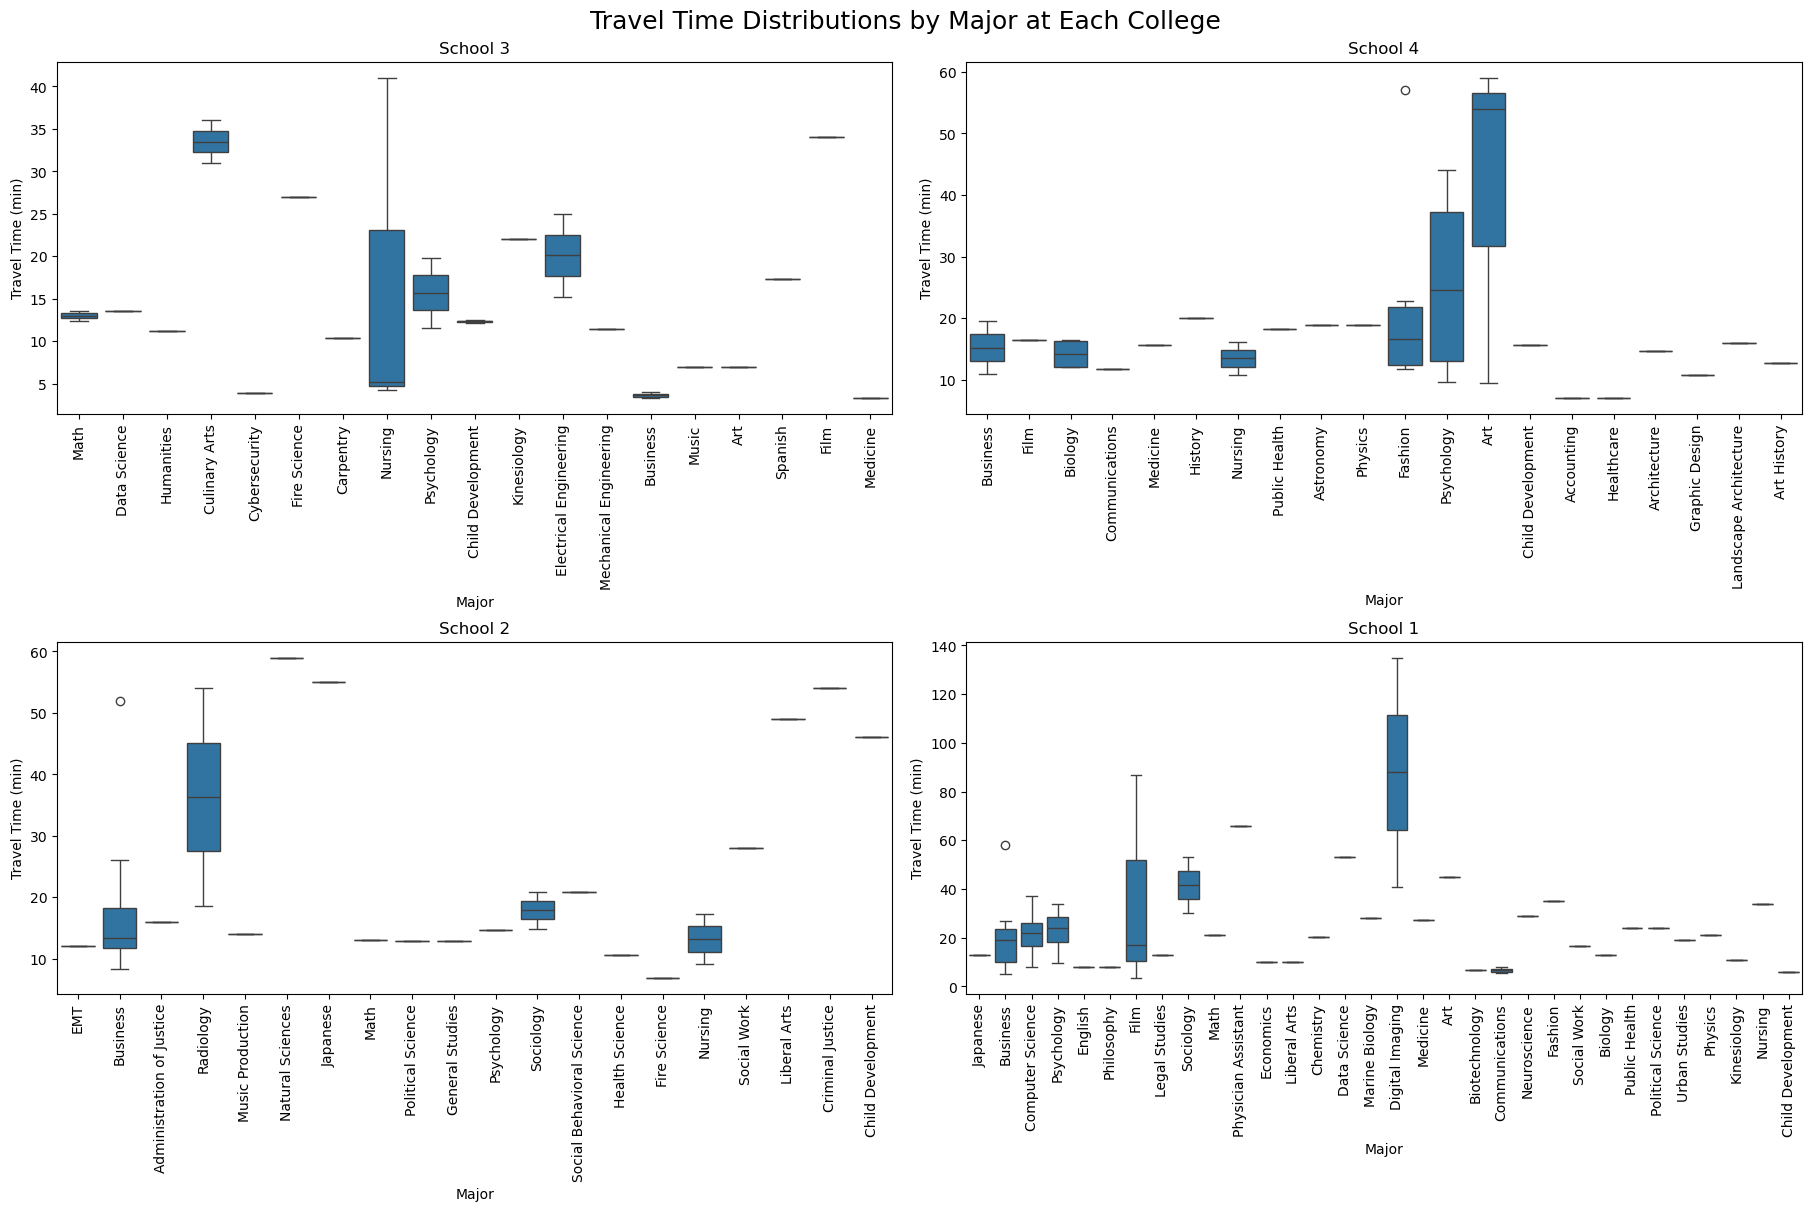

In [26]:

# Ensure all entries in 'Question_9' are strings
clean['Question_9'] = clean['Question_9'].astype(str)

# Split on comma
clean['Question_9'] = clean['Question_9'].str.split(',')

# Explode
clean = clean.explode('Question_9')

# Strip whitespace
clean['Question_9'] = clean['Question_9'].str.strip()

# Optional: remove rows where the result is "nan" after string conversion
clean = clean[clean['Question_9'].str.lower() != 'nan']

# Reset index
clean = clean.reset_index(drop=True)



# Define responses to drop (lowercase for comparison)
to_drop = ['Unknown', 'Undeclared', 'Undecided']

# Drop rows where 'Question_9' matches any of the to_drop values (case-insensitive)
clean = clean[~clean['Question_9'].str.lower().isin(to_drop)]

# Optional: reset index
clean = clean.reset_index(drop=True)


clean

# First, standardize the column for consistency (remove extra spaces, unify casing)
clean['Question_6'] = clean['Question_6'].str.strip()

# Then, split into separate DataFrames
s3 = clean[clean['Question_6'] == '3'].copy()
s4 = clean[clean['Question_6'] == '4'].copy()
s2 = clean[clean['Question_6'] == '2'].copy()
s1 = clean[clean['Question_6'] == '1'].copy()


# Dictionary to map college names to DataFrames
college_dfs = {
    "School 3": s3,
    "School 4": s4,
    "School 2": s2,
    "School 1": s1
}

# Set up 2x2 subplot layout
fig, axes = plt.subplots(2, 2, figsize=(18, 12), constrained_layout=True)
axes = axes.flatten()

# Generate a boxplot for each college
for ax, (college_name, df) in zip(axes, college_dfs.items()):
    if not df.empty:
        # Remove rows with missing majors
        df = df.dropna(subset=["Question_9"]).copy()
        df["Question_9"] = df["Question_9"].astype(str)

        # Split multiple majors and explode into separate rows
        df["Question_9"] = df["Question_9"].str.split(",\s*")
        df = df.explode("Question_9")

        # Remove 'Unknown', 'Undeclared', 'Undecided'
        df = df[~df["Question_9"].str.strip().isin(["Unknown", "Undeclared", "Undecided"])]

        # Plot boxplot
        sns.boxplot(data=df, x="Question_9", y="tt", ax=ax)
        ax.set_title(college_name)
        ax.set_xlabel("Major")
        ax.set_ylabel("Travel Time (min)")
        ax.tick_params(axis='x', rotation=90)
    else:
        ax.set_visible(False)

# Add main title
plt.suptitle("Travel Time Distributions by Major at Each College", fontsize=18)
plt.show()

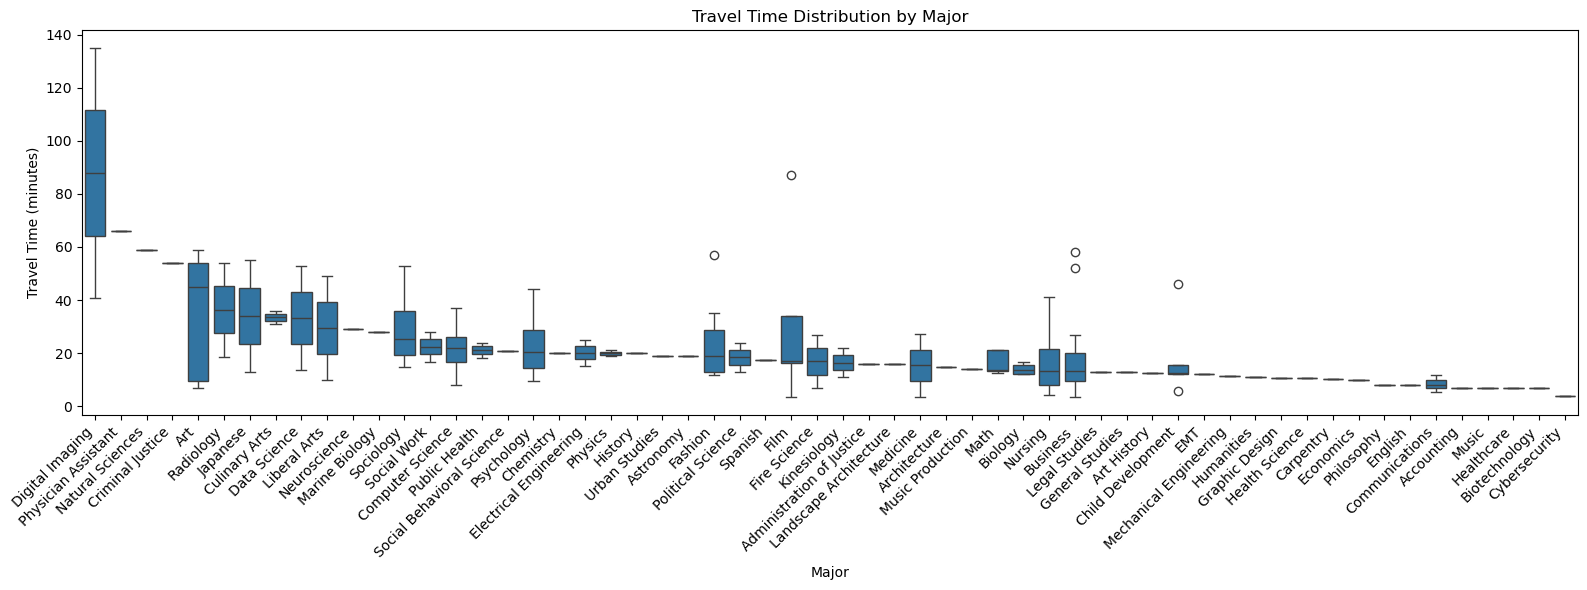

In [22]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# --- Step 1: Prepare ---
clean = clean.copy()
clean['Question_9'] = clean['Question_9'].astype(str)

# Drop unwanted entries
to_remove = ['undecided', 'unknown', 'undeclared']
clean = clean[~clean['Question_9'].str.lower().isin(to_remove)]

# --- Step 2: Clean and split majors ---
clean['Question_9'] = clean['Question_9'].str.replace(r"[\[\]']", '', regex=True)
clean['Question_9'] = clean['Question_9'].str.replace('\n', ' ')
clean['Question_9'] = clean['Question_9'].str.replace('/', ',')
clean['Question_9'] = clean['Question_9'].str.replace(' and ', ',')
clean['Question_9'] = clean['Question_9'].str.split(',')

# Explode into one major per row
clean = clean.explode('Question_9')

# Strip whitespace and drop empty
clean['Question_9'] = clean['Question_9'].str.strip()
clean = clean[clean['Question_9'] != '']
clean = clean[~clean['Question_9'].str.lower().isin(to_remove)]

# --- Step 3: Plot ---
plt.figure(figsize=(16, 6))
order = clean.groupby('Question_9')['tt'].median().sort_values(ascending=False).index

sns.boxplot(data=clean, x='Question_9', y='tt', order=order)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Major')
plt.ylabel('Travel Time (minutes)')
plt.title('Travel Time Distribution by Major')
plt.tight_layout()
plt.show()


Mean travel time (Unique Majors): 22.35
Mean travel time (Non-Unique Majors): 21.44


C:\Users\jcoll\AppData\Local\Temp\ipykernel_29444\756761949.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=tt_data, x='Uniqueness', y='tt', palette='Set2')


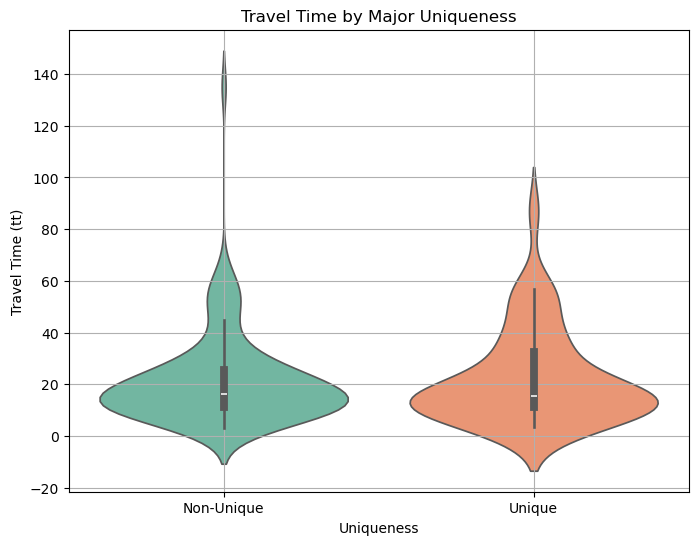

T-statistic: 0.280
P-value: 0.7802
❌ No statistically significant difference in travel time.


In [23]:

from scipy.stats import ttest_ind

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import pandas as pd

# Create a new DataFrame with just the columns we need
tt_data = clean[['tt', 'Unique to School']].dropna()

# Map 1 → "Unique", 0 → "Non-Unique" for clarity
tt_data['Uniqueness'] = tt_data['Unique to School'].map({1: 'Unique', 0: 'Non-Unique'})

# Descriptive stats
mean_unique = tt_data[tt_data['Uniqueness'] == 'Unique']['tt'].mean()
mean_nonunique = tt_data[tt_data['Uniqueness'] == 'Non-Unique']['tt'].mean()

print(f"Mean travel time (Unique Majors): {mean_unique:.2f}")
print(f"Mean travel time (Non-Unique Majors): {mean_nonunique:.2f}")

# Seaborn boxplot
plt.figure(figsize=(8, 6))
sns.violinplot(data=tt_data, x='Uniqueness', y='tt', palette='Set2')
plt.ylabel("Travel Time (tt)")
plt.title("Travel Time by Major Uniqueness")
plt.grid(True)
plt.show()

# Welch's t-test
group_unique = tt_data[tt_data['Uniqueness'] == 'Unique']['tt']
group_nonunique = tt_data[tt_data['Uniqueness'] == 'Non-Unique']['tt']
t_stat, p_value = ttest_ind(group_unique, group_nonunique, equal_var=False)

print(f"T-statistic: {t_stat:.3f}")
print(f"P-value: {p_value:.4f}")

# Interpretation
if p_value < 0.05:
    print("✅ The difference in travel time is statistically significant.")
else:
    print("❌ No statistically significant difference in travel time.")



C:\Users\jcoll\AppData\Local\Temp\ipykernel_29444\671334534.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Uniqueness', y='tt', ax=axes[i], palette=color_palette, order=["Unique", "Non-Unique"])
C:\Users\jcoll\AppData\Local\Temp\ipykernel_29444\671334534.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x='Uniqueness', y='tt', ax=axes[i], palette=color_palette, order=["Unique", "Non-Unique"])
C:\Users\jcoll\AppData\Local\Temp\ipykernel_29444\671334534.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot

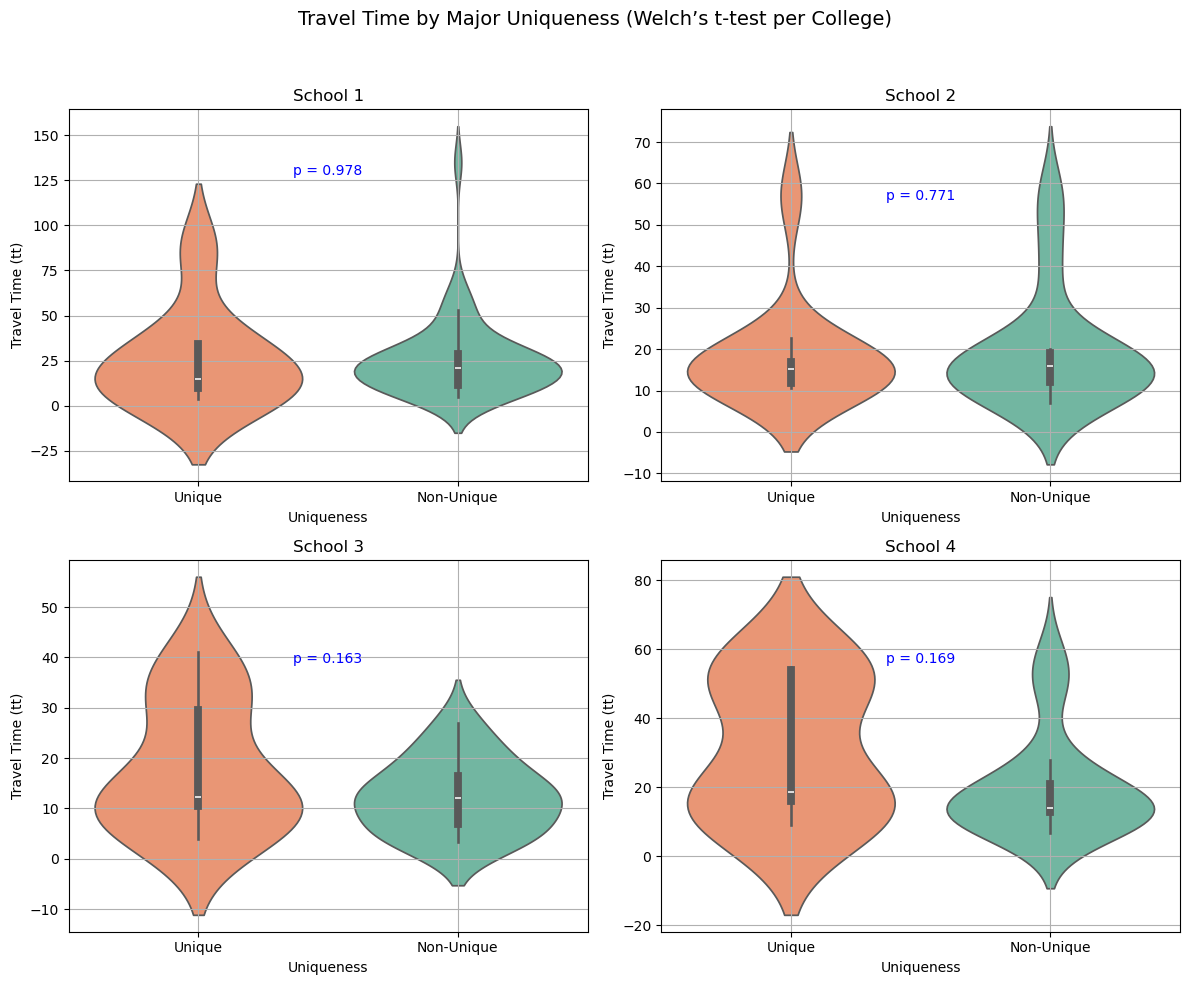

In [27]:
# Filter by college name in 'Question_6'
s1 = clean[clean['Question_6'] == '1']
s4 = clean[clean['Question_6'] == '4']
s3 = clean[clean['Question_6'] == '3']
s2 = clean[clean['Question_6'] == '2']



# Put your school DataFrames into a list for easy looping
school_dfs = {
    "1": s1,
    "4": s4,
    "3": s3,
    "2": s2
}



# Set exact color matches
color_palette = {"Unique": "#fc8d62", "Non-Unique": "#66c2a5"}

# Prepare subplots: 2 rows, 2 columns
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle("Travel Time by Major Uniqueness (Welch’s t-test per College)", fontsize=14)

# Flatten axes for iteration
axes = axes.flatten()

# Loop through each school DataFrame
for i, (school_name, df) in enumerate(school_dfs.items()):
    df = df.dropna(subset=['tt', 'Unique to School'])

    # Map 0/1 to labels
    df['Uniqueness'] = df['Unique to School'].map({1: 'Unique', 0: 'Non-Unique'})

    # Welch’s t-test
    group_unique = df[df['Uniqueness'] == 'Unique']['tt']
    group_nonunique = df[df['Uniqueness'] == 'Non-Unique']['tt']
    if len(group_unique) > 1 and len(group_nonunique) > 1:
        t_stat, p_val = ttest_ind(group_unique, group_nonunique, equal_var=False)
    else:
        p_val = float('nan')

    # Seaborn boxplot with consistent colors
    sns.violinplot(data=df, x='Uniqueness', y='tt', ax=axes[i], palette=color_palette, order=["Unique", "Non-Unique"])

    #axes[i].set_title(f"{school_name}")
    axes[i].set_title(f"School {i+1}")
    axes[i].set_ylabel("Travel Time (tt)")
    axes[i].grid(True)

    # Annotate with p-value
    max_tt = df['tt'].max()
    axes[i].text(0.5, max_tt * 0.95, f"p = {p_val:.3f}", ha='center', fontsize=10, color='blue')

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


